In [4]:
import os
import sys
import glob
import re

import warnings
warnings.filterwarnings("ignore")

from pyprojroot.here import here

sys.path.insert(1, str(here('bin')))
from customPythonFunctions import generate_split_dir

import matplotlib
import pandas as pd
import scanpy as sc
import anndata as ad

overwriteData = True
overwriteFigure = True

# Directory where the notebook is stored
currDir = os.getcwd()

In [2]:
# SANKEY DIAGRAM FUNCTION EDIT FROM:
# https://medium.com/kenlok/how-to-create-sankey-diagrams-from-dataframes-in-python-e221c1b4d6b0

def genSankey(df,cat_cols=[], colors = 'Set1', value_cols='',title='Sankey Diagram', size = 10):
    # maximum of 6 value cols -> 6 colors
    #colorPalette = ['#4B8BBE','#306998','#FFE873','#FFD43B','#646464']
    labelList = []
    colorNumList = []
    for catCol in cat_cols:
        labelListTemp =  list(set(df[catCol].values))
        colorNumList.append(len(labelListTemp))
        labelList = labelList + labelListTemp
        
    # remove duplicates from labelList
    labelList = list(dict.fromkeys(labelList))

    if isinstance(colors, list):
        colorPalette = colors
    else:
        nCol = len(cat_cols)
        cmap = matplotlib.colormaps.get_cmap(colors)
        colorPalette = ['#{:02x}{:02x}{:02x}'.format(round(cmap(c/nCol)[0]*255), round(cmap(c/nCol)[1]*255), round(cmap(c/nCol)[2]*255)) for c in range(nCol)]

    # define colors based on number of levels
    colorList = []
    for idx, colorNum in enumerate(colorNumList):
        colorList = colorList + [colorPalette[idx]]*colorNum
        
    # transform df into a source-target pair
    for i in range(len(cat_cols)-1):
        if i==0:
            sourceTargetDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            sourceTargetDf.columns = ['source','target','count']
        else:
            tempDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            tempDf.columns = ['source','target','count']
            sourceTargetDf = pd.concat([sourceTargetDf,tempDf])
        
        sourceTargetDf = sourceTargetDf.groupby(['source','target']).agg({'count':'sum'}).reset_index()
        
    # add index for source-target pair
    sourceTargetDf['sourceID'] = sourceTargetDf['source'].apply(lambda x: labelList.index(x))
    sourceTargetDf['targetID'] = sourceTargetDf['target'].apply(lambda x: labelList.index(x))

    labelList = [re.sub(r'\([^)]*\)', '', l) for l in labelList]
    labelList = [l.replace('_', ' ') for l in labelList]
    
    
    # creating the sankey diagram
    data = dict(
        type='sankey',
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(
            color = "black",
            width = 0.5
          ),
          label = labelList,
          color = colorList
        ),
        link = dict(
          source = sourceTargetDf['sourceID'],
          target = sourceTargetDf['targetID'],
          value = sourceTargetDf['count']
        )
      )
    
    layout =  dict(
        title = title,
        font = dict(
          size = size
        )
    )
       
    fig = dict(data=[data], layout=layout)
    return fig

# Retrieve pandas dataframes with annotations

**Loading pandas dataFrame**

In [3]:
fullAnnotationDF = pd.read_pickle(here('02_fromCellLineages_to_CellTypes/master_clusterAnnotDF_final.pkl'))
fullAnnotationDF.head()

,annotation_step_1,annotation_step_2,annotation_step_3,annotation_step_4,annotation_step_5,Level1,Level2
cellID,,,,,,,
SCGT00_L051_I53.3P_T0_AACCAACGTGGGATTG,pDC,pDC,pDC,pDC,pDC,pDC,pDC
SCGT00_L051_I58.3P_T0_ACCTGAAAGTGCCAGA,pDC,pDC,pDC,pDC,pDC,pDC,pDC
SCGT00_L051_I53.3P_T0_ACTATGGAGGCGCTCT,pDC,pDC,pDC,pDC,pDC,pDC,pDC
SCGT00_L051_I55.3P_T0_ACTTTCACATGGGTTT,pDC,pDC,pDC,pDC,pDC,pDC,pDC
SCGT00_L051_I52.3P_T0_ATCACAGTCATCGGGC,pDC,pDC,pDC,pDC,pDC,pDC,pDC


In [4]:
fullAnnotationDF.value_counts(['Level1'], dropna=False)

Level1          
Mono                1049149
T_CD4_Naive          792955
T_CD4_NonNaive       712248
T_CD8_NonNaive       523322
ILC                  376885
B                    356874
LowQuality_cells     241452
Doublets             240766
T_CD8_Naive          213776
Platelets            154085
UTC                  115097
DC                    47076
Cycling_cells         45181
pDC                   22902
Plasma                16854
Progenitors            7033
RBC                    2485
Name: count, dtype: int64

### Alluvion plot shows changes in cell groups

In [5]:
selCol = ['annotation_step_1','annotation_step_2','annotation_step_3','annotation_step_4','annotation_step_5', 'Level2', 'Level1']

# Loading single-cell data

**Scanpy object with count raw and normalized**

In [6]:
adata = sc.read_h5ad(here("01_data_processing/results/03_INFLAMMATION_main_normalized.h5ad"))
adata

AnnData object with n_obs × n_vars = 4918140 × 22838
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'technology', 'patientID', 'disease', 'timepoint_replicate', 'treatmentStatus', 'therapyResponse', 'sex', 'age', 'BMI', 'binned_age', 'diseaseStatus', 'smokingStatus', 'ethnicity', 'institute', 'diseaseGroup', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_plt', 'log1p_total_counts_plt', 'pct_counts_plt', 'doublet_score', 'predicted_doublet', 'S_score', 'G2M_score', 'phase'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status', 'mt', 'ribo', 'hb', 'plt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'chemistry_colors', 'log1

**Import annotation**

In [7]:
adata.obs = adata.obs.merge(fullAnnotationDF[['Level1', 'Level2']], left_index=True, right_index=True, how='left')

# Remove discarded cells

We also check the distribution of the number of cells in each cell-types among patient and disease.

In [8]:
adataFilt = adata[~adata.obs['Level1'].isin(['Doublets','LowQuality_cells']),:].copy()
adataFilt

AnnData object with n_obs × n_vars = 4435922 × 22838
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'technology', 'patientID', 'disease', 'timepoint_replicate', 'treatmentStatus', 'therapyResponse', 'sex', 'age', 'BMI', 'binned_age', 'diseaseStatus', 'smokingStatus', 'ethnicity', 'institute', 'diseaseGroup', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_plt', 'log1p_total_counts_plt', 'pct_counts_plt', 'doublet_score', 'predicted_doublet', 'S_score', 'G2M_score', 'phase', 'Level1', 'Level2'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status', 'mt', 'ribo', 'hb', 'plt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'chem

In [9]:
del adata

In [10]:
patientXdisease = pd.DataFrame(adataFilt.obs[['sampleID','disease']].drop_duplicates().value_counts('disease')).reset_index()
patientXdisease.columns = ['disease','tot_patient']
patientXdisease

,disease,tot_patient
0,healthy,270
1,SLE,142
2,COVID,117
3,RA,38
4,sepsis,35
5,PSA,26
6,PS,26
7,UC,22
8,HNSCC,21
9,CD,21


In [11]:
adataFilt.obs['sampleID'].unique().shape

(817,)

In [12]:
print(sorted(set(adataFilt.obs.Level1.unique().tolist())))

['B', 'Cycling_cells', 'DC', 'ILC', 'Mono', 'Plasma', 'Platelets', 'Progenitors', 'RBC', 'T_CD4_Naive', 'T_CD4_NonNaive', 'T_CD8_Naive', 'T_CD8_NonNaive', 'UTC', 'pDC']


In [13]:
print(sorted(set(adataFilt.obs.Level2.unique().tolist())))

['B_IFNresponder', 'B_Memory_ITGAX', 'B_Memory_switched', 'B_Memory_unswitched', 'B_Naive', 'B_Naive_activated', 'B_Progenitors', 'B_Transitional', 'DC4', 'DC5', 'DC_CCR7', 'DC_Proliferative', 'HSC_LMP', 'HSC_MEMP', 'HSC_MMP', 'MAIT', 'MAIT_17', 'Mono_IFNresponse', 'Mono_classical', 'Mono_inflammatory', 'Mono_nonClassical', 'Mono_regulatory', 'NK_CD16high', 'NK_CD56dimCD16', 'NK_CD56high', 'NK_IFN1response', 'NK_Proliferative', 'NK_adaptive', 'NK_lowRibocontent', 'Plasma_IGHA', 'Plasma_IGHG', 'Plasma_Proliferative', 'Plasma_XBP1', 'Platelets', 'RBC', 'T_CD4_CM', 'T_CD4_CM_ribo', 'T_CD4_EM', 'T_CD4_EMRA', 'T_CD4_Naive', 'T_CD4_eff', 'T_CD8_CM', 'T_CD8_CM_stem', 'T_CD8_EM_CX3CR1high', 'T_CD8_EM_CX3CR1int', 'T_CD8_IFNresponse', 'T_CD8_Mem_cytotoxic', 'T_CD8_Naive', 'T_CD8_activated', 'T_CD8_arrested', 'T_CD8_eff_HOBIT', 'T_Progenitors', 'T_Proliferative', 'Th0', 'Th1', 'Th2', 'Tregs', 'Tregs_activated', 'cDC1', 'cDC2', 'cDC3', 'gdT_V1', 'gdT_V2_Vγ9', 'pDC']


In [15]:
cellTypeXpatient = pd.DataFrame(adataFilt.obs.groupby(['Level1','sampleID'], observed = False).size()).reset_index()
cellTypeXpatient.columns = ['Level1','sampleID','Count']
cellTypeXpatient.sort_values('Count')
cellTypeXpatient = cellTypeXpatient.merge(adataFilt.obs[['sampleID','disease']].drop_duplicates(), on='sampleID', how='left') 
cellTypeXpatient

,Level1,sampleID,Count,disease
0,B,COMBAT2022_G05061_T0,410,COVID
1,B,COMBAT2022_G05064_T0,318,COVID
2,B,COMBAT2022_G05077_T0,341,COVID
3,B,COMBAT2022_G05078_T0,129,COVID
4,B,COMBAT2022_G05105_T0,384,COVID
...,...,...,...,...
12250,pDC,Zhang2023_P191112_T0,14,HBV
12251,pDC,Zhang2023_P191126_T0,32,HBV
12252,pDC,Zhang2023_P191127_T0,13,HBV
12253,pDC,Zhang2023_P191210_T0,10,HBV


In [16]:
threshold = 5
patient_with_no_cellTypes = cellTypeXpatient.query('Count < @threshold')[['Level1','sampleID','disease']].groupby(['Level1','disease'], observed = True).count().reset_index().merge(patientXdisease, on='disease', how='left')
patient_with_no_cellTypes['proportion']  = patient_with_no_cellTypes['sampleID'] / patient_with_no_cellTypes['tot_patient']
patient_with_no_cellTypes.loc[~patient_with_no_cellTypes['Level1'].isin(['RBC','Progenitors','Platelets','Plasma']),:].sort_values('proportion', ascending=False)

,Level1,disease,sampleID,tot_patient,proportion
116,pDC,HIV,5,6,0.833333
118,pDC,NPC,8,10,0.800000
124,pDC,flu,8,11,0.727273
109,UTC,flu,7,11,0.636364
126,pDC,sepsis,22,35,0.628571
...,...,...,...,...,...
21,DC,healthy,3,270,0.011111
98,T_CD8_NonNaive,COVID,1,117,0.008547
4,Cycling_cells,COVID,1,117,0.008547
9,Cycling_cells,SLE,1,142,0.007042


As you can see, we annotated a very few number of pDC cells. Some patients show less than 5cell. In particular diseases (e.g., HIV, and Sepsis) are affected.

**Cleaning object to keep only relevant fields for the next steps**

In [17]:
adataFilt.obs.drop(['timepoint_replicate', 'treatmentStatus', 'therapyResponse', 'age', 'BMI', 'technology', 'patientID',
                     'diseaseStatus', 'smokingStatus', 'ethnicity', 'institute', 'diseaseGroup', 'n_genes_by_counts', 
                     'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 
                     'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 
                     'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_plt', 'log1p_total_counts_plt', 
                     'pct_counts_plt', 'doublet_score', 'predicted_doublet', 'S_score', 'G2M_score', 'phase'],
                    axis=1,inplace=True)
adataFilt.var.drop(['mt', 'ribo', 'hb', 'plt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 
                         'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'],axis=1, inplace=True)

In [18]:
adataFilt.X = adataFilt.layers['counts'].copy()

In [19]:
del adataFilt.layers
del adataFilt.uns

In [25]:
adataFilt

AnnData object with n_obs × n_vars = 4435922 × 22838
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'disease', 'sex', 'binned_age', 'Level1', 'Level2'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status'

# Saving object

In [26]:
if overwriteData:
    adataFilt.write(here('02_fromCellLineages_to_CellTypes/INFLAMMATION_main_annotated_LowQFilt.h5ad'), compression='gzip')

## Data exploring

In [5]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Patch
import plotly.io as pio

# Import functions
sys.path.insert(1, str(here('bin')))
from customPalette import *

dpi_fig_save = 300
sc.set_figure_params(dpi=100, dpi_save=dpi_fig_save, vector_friendly=True)

In [6]:
adataFilt = ad.read_h5ad(here('02_fromCellLineages_to_CellTypes/INFLAMMATION_main_annotated_LowQFilt.h5ad'))
adataFilt

AnnData object with n_obs × n_vars = 4435922 × 22838
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'disease', 'sex', 'binned_age', 'Level1', 'Level2'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status'

In [30]:
obs_df = adataFilt.obs
obs_df['Level1'] = pd.Categorical(obs_df['Level1'], categories=annotation_Level1_LowQFilt_sortednames)

In [31]:
agg_data = obs_df.groupby(['disease', 'Level1']).size().unstack(fill_value=0)
agg_data = agg_data.div(agg_data.sum(axis=1), axis=0) * 100  # Calculate percentages

agg_data.index = agg_data.index.astype(str)
agg_data = agg_data.reindex(disease_sortednames)
agg_data.head()

Level1,B,Plasma,pDC,DC,Mono,T_CD4_Naive,T_CD4_NonNaive,T_CD8_Naive,T_CD8_NonNaive,UTC,ILC,Cycling_cells,Progenitors,Platelets,RBC
disease,,,,,,,,,,,,,,,
healthy,5.823138,0.210189,0.787424,1.220902,18.525226,20.892542,17.928223,5.619210,11.117095,4.076011,9.722755,0.579613,0.152048,3.324005,0.021622
CRC,8.255487,0.266132,0.330780,1.148571,31.347577,15.585437,14.451951,2.672097,8.213466,3.223756,11.094590,0.604454,0.092661,2.104276,0.608764
HNSCC,5.052654,0.115812,0.452477,1.117725,32.804546,11.874815,18.435724,1.686014,12.308438,1.844919,13.038326,0.576369,0.056560,0.587142,0.048480
NPC,7.389490,0.609569,0.033751,0.299671,5.789883,12.495142,17.438174,4.774275,32.611942,3.883445,12.560599,1.087201,0.039888,0.986970,0.000000
BRCA,11.892168,0.315562,0.474845,1.247220,12.703612,14.759272,17.205626,5.160185,14.407646,1.686001,6.999459,0.892589,0.135241,12.117569,0.003005


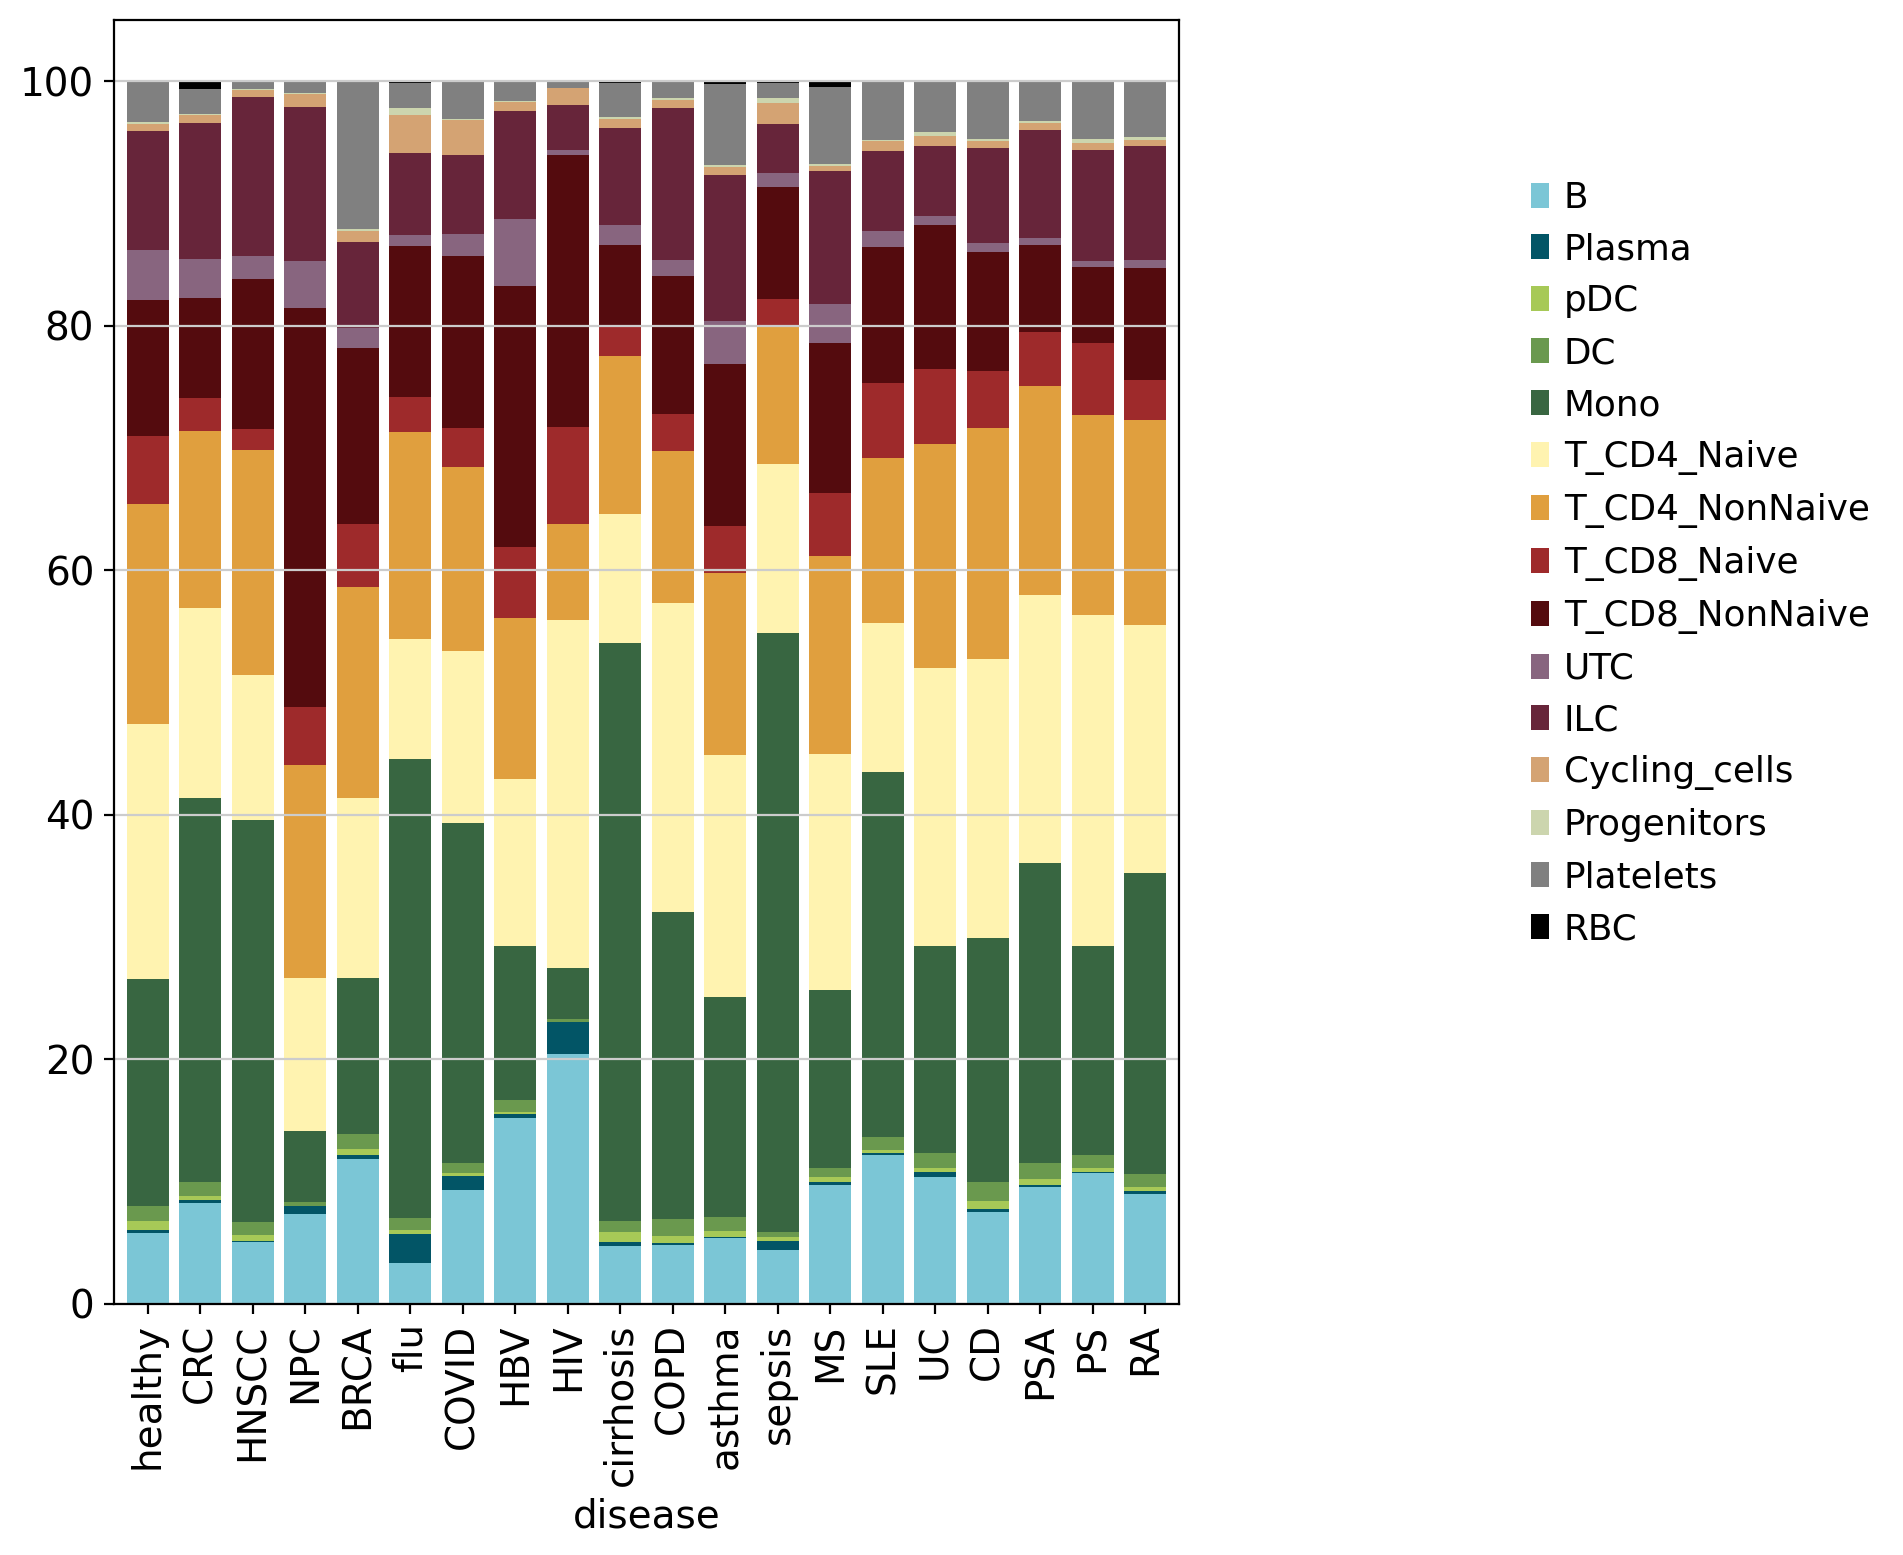

In [44]:
# Plotting the stacked bar plot

fig, ax = plt.subplots(figsize=(8, 8))
agg_data.plot(kind='bar', stacked=True, color=annotation_Level1_palette, width=0.8, ax=ax)

# Adding labels and title
ax.xaxis.grid(False)
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.3, 0.9), ncol=1, frameon=False)
plt.tight_layout()

plt.savefig(here(f"02_fromCellLineages_to_CellTypes/figures/MAINdata_Level1Proportions_overview.pdf"),
dpi=300,
bbox_inches='tight',
pad_inches=0.1
)

plt.show()